In [1]:
from __future__ import division
from __future__ import print_function

from builtins import str
from builtins import range
from past.utils import old_div

try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:       
    print('Not IPYTHON')    
    pass

# Import the usual suspects
import sys
import numpy as np
from time import time
from scipy.sparse import coo_matrix
import psutil
import glob
import os
import scipy
from ipyparallel import Client
import matplotlib as mpl
import pylab as pl
pl.ion()

# Import the relevant files from CaImAn
import caiman as cm
from caiman.components_evaluation import evaluate_components
from caiman.utils.visualization import plot_contours,view_patches_bar,nb_plot_contour,nb_view_patches
from caiman.base.rois import extract_binary_masks_blob
import caiman.source_extraction.cnmf as cnmf

# Import bokeh - for doing interactive plotting on our components later
import bokeh.plotting as bpl
from bokeh.io import vform,hplot,vplot,gridplot
from bokeh.models import CustomJS, ColumnDataSource, Slider

numba not found


In [5]:
n_processes = np.maximum(np.int(psutil.cpu_count()),1) # roughly number of cores on your machine minus 1
print(('using ' + str(n_processes) + ' processes'))

#%% start cluster for efficient computation
single_thread=False

if single_thread:
    dview=None
else:    
    try:
        c.close()
    except:
        print('C was not existing, creating one')
        
    print("Stopping  cluster to avoid unnencessary use of memory....")
    sys.stdout.flush()  

    cm.stop_server()
    cm.start_server()        
    c=Client()

    print(('Using '+ str(len(c)) + ' processes'))
    dview=c[:len(c)]

using 12 processes
C was not existing, creating one
Stopping  cluster to avoid unnencessary use of memory....
Stopping cluster...
NOT SLURM
Waiting for cluster to stop....... done
Starting cluster...Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
............Using 12 processes


# Load all the tiff Files Into a Single Memory Mappable File

In [33]:
base_folder='/home/absplab/Packages/CaImAn/WN150904OM269-1'
force_remap = True

subwindow = None # (slice(10,100), slice(12,200)) # set to None for the full window
downsample_factor = 1 # use .2 or .1 if file is large and you want a quick answer
remove_init = 0

# check if there aren't already mapped files in the directory
pre_mapped_files = [os.path.abspath(file) for file in glob.glob(os.path.join(base_folder,'Yr_*'))]

# if there were and we're don't want to replace them, just take the first file name matching 'Yr_' as the memmap name
if len(pre_mapped_files) and not force_remap:
    
    mmap_file_name = pre_mapped_files[0]
    print('Using premapped file of name: ' + mmap_file_name)
    print('Set force_remap to True to refresh this file')

# otherwise we fish out all the tif files in the directory and pass them to save_memmap_each 
# for memmapping and then join them into a single file with save_memmap_join
else:
    print('Remapping was forced or no memmapped file could be found, remapping...')

    tif_files = [os.path.abspath(file) for file in glob.glob(os.path.join(base_folder,'*.tif'))]

    if len(tif_files) == 0:
        raise Exception("No tif files were found in the specified directory")

    tif_files.sort()

    mmap_files = cm.save_memmap_each(tif_files, dview=dview, base_name='Yr', resize_fact=(1, 1, downsample_factor), remove_init=remove_init, idx_xy=subwindow)
    mmap_files.sort()
    mmap_file_name = cm.save_memmap_join(mmap_files, base_name='Yr', n_chunks=12, dview=dview)

    print('Using memmap file of name: ' + mmap_file_name)

Remapping was forced or no memmapped file could be found, remapping...
('/home/absplab/Packages/CaImAn/WN150904OM269-1/Yr0000_d1_256_d2_256_d3_1_order_C_frames_3000_.mmap', 3000)
/home/absplab/Packages/CaImAn/WN150904OM269-1/Yr_d1_256_d2_256_d3_1_order_C_frames_3000_.mmap
Deleting big mov
Using memmap file of name: /home/absplab/Packages/CaImAn/WN150904OM269-1/Yr_d1_256_d2_256_d3_1_order_C_frames_3000_.mmap


# Visualise the Correlation Image

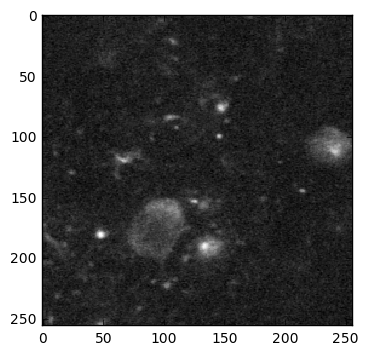

In [34]:
Yr, dims, T = cm.load_memmap(mmap_file_name)
Y = np.reshape(Yr, dims+(T,), order='F')

Cn = cm.local_correlations(Y)
pl.imshow(Cn,cmap='gray',interpolation='none')   

del Yr, Y

# Parameterise the Analysis

In [46]:
# half-size of the patches in pixels. rf=128, patches are 256x256
rf = 64 #128 

# amount of overlap between the patches in pixels    
stride = 32 #64 

# number of neurons expected per patch
K = 50 

# expected half size of neurons
gSig = [7,7] 

# merging threshold, max correlation allowed
merge_thresh = 0.8 

# order of the autoregressive system
p = 2 

# unitless number accounting how much memory should be used.
memory_fact = 1

# save filename for results (set to None to skip save)
save_file = 'results_WN150904OM269-1.npz'

# populate the 'options' dictionary
options = cnmf.utilities.CNMFSetParms((dims, T), n_processes, p=0, gSig=gSig, K=K, ssub=1, tsub=4, nIter_patch=2, thr=merge_thresh)

using 12 processes
using 1000 pixels per process
using 1000 block_size


# Run the Analysis on the Patches

In [47]:
# this just overlays the spatial components from each of the patches onto the full window, so there'll be a lot of overlap
A, C, YrA, b, f, sn, optional_outputs = cnmf.map_reduce.run_CNMF_patches(mmap_file_name, (dims[0], dims[1], T), options, rf=rf, stride=stride, dview=dview, memory_fact=memory_fact, gnb=1)

9
79.8499078751
Transforming patches into full matrix
Generating backgound


In [48]:
if save_file is not None:
    np.savez(save_file, A=A.todense(), C=C, sn=sn, b=b, f=f, dims=dims, T=T)

In [49]:
if save_file is not None:
    with np.load(save_file) as res:
        A = scipy.sparse.csc_matrix(res['A'])
        C, sn, b, f, dims, T = res['C'], res['sn'], res['b'], res['f'], res['dims'], res['T']

# Now Reconfigure the Analysis to Look at the Full Window

In [50]:
options = cnmf.utilities.CNMFSetParms((dims, T), n_processes, p=0, gSig=gSig, K=A.shape[-1], thr=merge_thresh)

# regulates the amount of memory used
pixels_per_process = np.minimum(np.int(np.prod(dims)/n_processes/(old_div(T,2000.))), np.int(old_div(np.prod(dims),n_processes)))
options['spatial_params']['n_pixels_per_process'] = pixels_per_process
options['temporal_params']['n_pixels_per_process'] = pixels_per_process

using 12 processes
using 1000 pixels per process
using 1000 block_size


# Merge Spatially Overlaping and Temporally Correlated Components

In [ ]:
A, C, nr, merged_ROIs, S, bl, c1, sn, g = cnmf.merging.merge_components(Yr,A,[],np.array(C),[],np.array(C),[],options['temporal_params'],options['spatial_params'],dview=dview,thr=options['merging']['thr'],mx=np.Inf)   

# Update the Temporal Components to get Yr

In [10]:
options['temporal_params']['p'] = 0
options['temporal_params']['fudge_factor'] = 0.96 #change if denoised traces time constant is wrong
options['temporal_params']['backend']='ipyparallel'
C_m,f_m,S_m,bl_m,c1_m,neurons_sn_m,g2_m,YrA_m = cnmf.temporal.update_temporal_components(Yr,A_m,b,C_m,f,dview=dview,bl=None,c1=None,sn=None,g=None,**options['temporal_params'])

using 12 processes
using 1000 pixels per process
using 1000 block_size
********** No neurons merged! ***************
Generating residuals
Forcing single thread for memory issues
parallel dot product block size: 1000
Start product
Transposing
999
1999
2999
3999
4999
5999
6999
7999
8999
9999
10999
11999
12999
13999
14999
15999
16999
17599
Done
1 out of total 50 temporal components updated
6 out of total 50 temporal components updated
18 out of total 50 temporal components updated
34 out of total 50 temporal components updated
50 out of total 50 temporal components updated
1 out of total 50 temporal components updated
5 out of total 50 temporal components updated
got unknown result: a853ca9e-4a7d-47d2-a132-31928b63ceda
12 out of total 50 temporal components updated
25 out of total 50 temporal components updated
39 out of total 50 temporal components updated
50 out of total 50 temporal components updated
stopping: overall temporal component not changing significantly


In [11]:
#%%
# frame rate in Hz
final_frate=10 

#%% get rid of eventually noisy components. 
# But check by visual inspection to have a feeling fot the threshold. Try to be loose, you will be able to get rid of more of them later!
tB = np.minimum(-2,np.floor(-5./30*final_frate))
tA = np.maximum(5,np.ceil(25./30*final_frate))
Npeaks=10
traces=C_m+YrA_m
#        traces_a=traces-scipy.ndimage.percentile_filter(traces,8,size=[1,np.shape(traces)[-1]/5])
#        traces_b=np.diff(traces,axis=1)
fitness_raw, fitness_delta, erfc_raw, erfc_delta, r_values, significant_samples = evaluate_components(Y, traces, A_m, C_m, b, f_m, final_frate=final_frate, remove_baseline=True, N=5, robust_std=False, Athresh = 0.1, Npeaks = Npeaks, thresh_C = 0.3)

idx_components_r=np.where(r_values>=.5)[0]
idx_components_raw=np.where(fitness_raw<-20)[0]        
idx_components_delta=np.where(fitness_delta<-10)[0]   


idx_components=np.union1d(idx_components_r,idx_components_raw)
idx_components=np.union1d(idx_components,idx_components_delta)  
idx_components_bad=np.setdiff1d(list(range(len(traces))),idx_components)

print(' ***** ')
print((len(traces)))
print((len(idx_components)))

Computing event exceptionality delta
Removing Baseline
Computing event exceptionality
Evaluating spatial footprint
 ***** 
50
2


/home/absplab/anaconda2/envs/CNMF/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
caiman/components_evaluation.py:181: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  mY = np.mean(Y[px,:][:,indexes],axis=-1)


Number of components:2


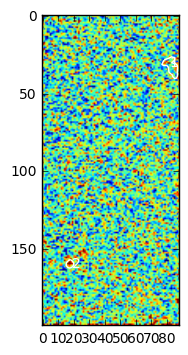

In [12]:
#%%
A_m=A_m[:,idx_components]
C_m=C_m[idx_components,:]   

#%% display components  DO NOT RUN IF YOU HAVE TOO MANY COMPONENTS
pl.figure()
crd = plot_contours(A_m,Cn,thr=0.9)

#%%
print(('Number of components:' + str(A_m.shape[-1])))

In [13]:
#%% UPDATE SPATIAL COMPONENTS
A2,b2,C2 = cnmf.spatial.update_spatial_components(Yr, C_m, f, A_m, sn=sn_tot,dview=dview, **options['spatial_params'])

found spatial support for each component
(17600, 2)
Starting Update Spatial Components
Updated Spatial Components
threshold
Computing residuals
parallel dot product block size: 1000
Start product
Filling
Computing A_bas
--- 1.12832593918 seconds ---
Remove temporary file created


In [14]:
#%% UPDATE TEMPORAL COMPONENTS
options['temporal_params']['p']=p
options['temporal_params']['fudge_factor']=0.96 #change if denoised traces time constant is wrong
C2,f2,S2,bl2,c12,neurons_sn2,g21,YrA = cnmf.temporal.update_temporal_components(Yr,A2,b2,C2,f,dview=dview, bl=None,c1=None,sn=None,g=None,**options['temporal_params'])
    

Generating residuals
Forcing single thread for memory issues
parallel dot product block size: 1000
Start product
Transposing
999
1999
2999
3999
4999
5999
6999
7999
8999
9999
10999
11999
12999
13999
14999
15999
16999
17599
Done
2 out of total 2 temporal components updated
2 out of total 2 temporal components updated
stopping: overall temporal component not changing significantly


In [15]:
#%% stop server and remove log files
log_files=glob.glob('Yr*_LOG_*')
for log_file in log_files:
    os.remove(log_file)

In [16]:
#%% order components according to a quality threshold and only select the ones wiht qualitylarger than quality_threshold. 
B = np.minimum(-2,np.floor(-5./30*final_frate))
tA = np.maximum(5,np.ceil(25./30*final_frate))
Npeaks=10
traces=C2+YrA
#        traces_a=traces-scipy.ndimage.percentile_filter(traces,8,size=[1,np.shape(traces)[-1]/5])
#        traces_b=np.diff(traces,axis=1)
fitness_raw, fitness_delta, erfc_raw, erfc_delta, r_values, significant_samples = evaluate_components(Y, traces, A2, C2, b2, f2, final_frate=final_frate, remove_baseline=True, N=5, robust_std=False, Athresh = 0.1, Npeaks = Npeaks, thresh_C = 0.3)

idx_components_r=np.where(r_values>=.6)[0]
idx_components_raw=np.where(fitness_raw<-60)[0]        
idx_components_delta=np.where(fitness_delta<-20)[0]   

min_radius=gSig[0]-2
masks_ws,idx_blobs,idx_non_blobs=extract_binary_masks_blob(
A2.tocsc(), min_radius, dims, num_std_threshold=1, 
minCircularity= 0.6, minInertiaRatio = 0.2,minConvexity =.8)

idx_components=np.union1d(idx_components_r,idx_components_raw)
idx_components=np.union1d(idx_components,idx_components_delta)  
idx_blobs=np.intersect1d(idx_components,idx_blobs)   
idx_components_bad=np.setdiff1d(list(range(len(traces))),idx_components)

print(' ***** ')
print((len(traces)))
print((len(idx_components)))
print((len(idx_blobs)))

Computing event exceptionality delta
Removing Baseline
Computing event exceptionality
Evaluating spatial footprint
0
1
 ***** 
2
1
0


Component:0


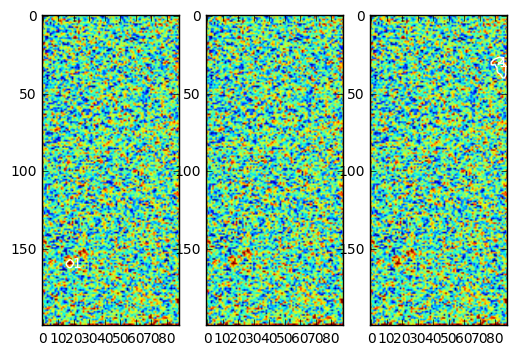

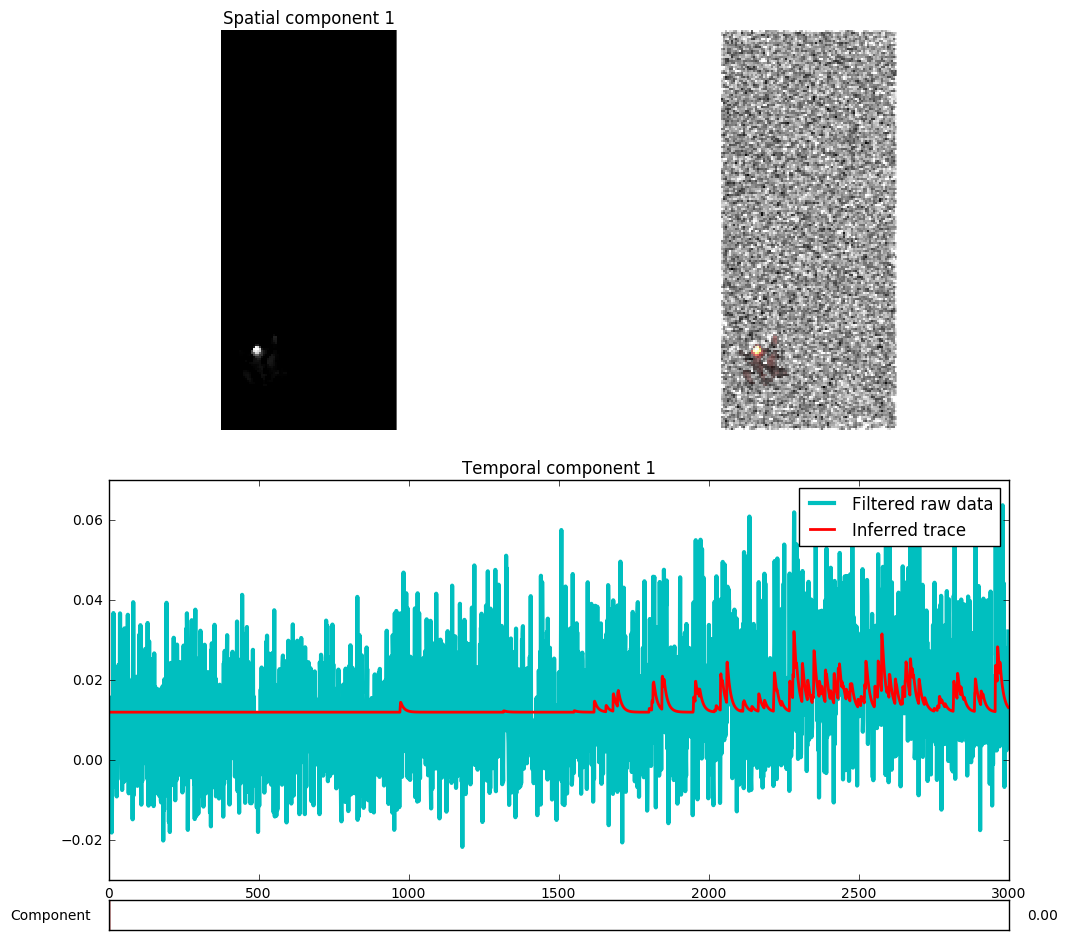

Component:0


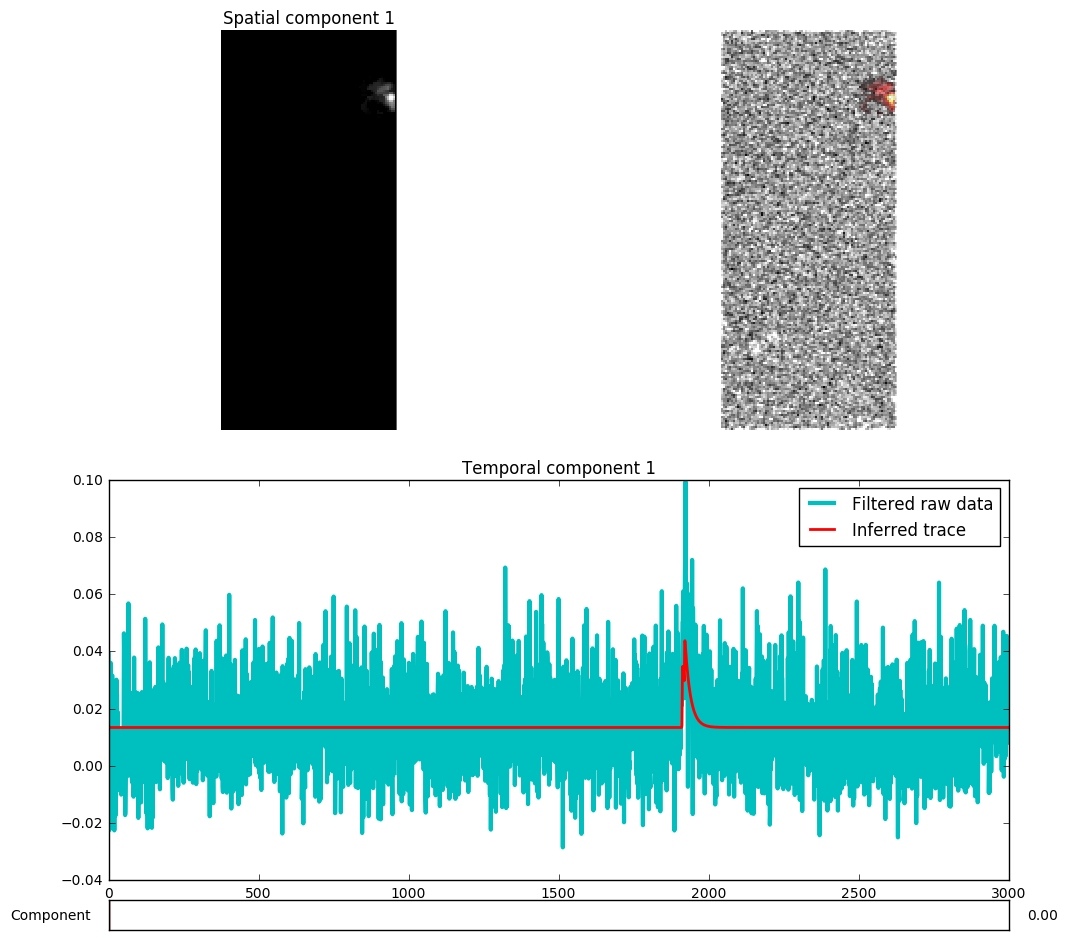

In [17]:
#%% visualize components
#pl.figure();
pl.subplot(1,3,1)
crd = plot_contours(A2.tocsc()[:,idx_components],Cn,thr=0.9)
pl.subplot(1,3,2)
crd = plot_contours(A2.tocsc()[:,idx_blobs],Cn,thr=0.9)
pl.subplot(1,3,3)
crd = plot_contours(A2.tocsc()[:,idx_components_bad],Cn,thr=0.9)
#%%
view_patches_bar(Yr,scipy.sparse.coo_matrix(A2.tocsc()[:,idx_components]),C2[idx_components,:],b2,f2, dims[0],dims[1], YrA=YrA[idx_components,:],img=Cn)  
#%%
view_patches_bar(Yr,scipy.sparse.coo_matrix(A2.tocsc()[:,idx_components_bad]),C2[idx_components_bad,:],b2,f2, dims[0],dims[1], YrA=YrA[idx_components_bad,:],img=Cn)  

In [18]:
bpl.output_notebook()

traces_fluo=nb_view_patches(Yr,A2.tocsc().todense(),C2,b2,f2,dims[0],dims[1],thr = 0.8,image_neurons=None)

Loading BokehJS ...

Loading BokehJS ...

/home/absplab/anaconda2/envs/CNMF/lib/python2.7/site-packages/bokeh/util/deprecation.py:33: BokehDeprecationWarning: bokeh.io.hplot() was deprecated in Bokeh 0.12.0 and will be removed, use bokeh.models.layouts.Row instead.
  warn(message)
/home/absplab/anaconda2/envs/CNMF/lib/python2.7/site-packages/bokeh/util/deprecation.py:33: BokehDeprecationWarning: bokeh.io.vform() was deprecated in Bokeh 0.12.0 and will be removed, use bokeh.models.layouts.WidgetBox instead.
  warn(message)
/home/absplab/anaconda2/envs/CNMF/lib/python2.7/site-packages/bokeh/util/deprecation.py:33: BokehDeprecationWarning: bokeh.models.layout.VBoxForm was deprecated in Bokeh 0.12.0 and will be removed, use bokeh.models.layouts.WidgetBox instead.
  warn(message)
/home/absplab/anaconda2/envs/CNMF/lib/python2.7/site-packages/bokeh/models/layouts.py:243: UserWarning: WARNING: Non-widgets added to VBoxForm! VBoxForm is deprecated and is
            being replaced with WidgetBox. WidgetBox does not allow you to add non

In [ ]:
#%% STOP CLUSTER
pl.close()
if not single_thread:    
    c.close()
    cm.stop_server()

# can I set this up to display only the components from a certain window in the frame? That way the analysis is whatever but the view can be changed nicely

In [ ]:

pl.subplot(1,2,1)
mpl.pyplot.imshow(A2.todense()[:,0].reshape(1024,1024)[13:50+2,52:81],interpolation='none')
pl.subplot(1,2,2)
mpl.pyplot.imshow(A2.todense()[:,1].reshape(1024,1024)[16:62+2,46:76],interpolation='none')

mpl.pyplot.show()



print(A2)

In [ ]:
comp = 199
idx = np.where(A2.todense()[:,comp].reshape(1024,1024) > 0)
mpl.pyplot.imshow(A2.todense()[:,comp].reshape(1024,1024)[min(idx[0]):max(idx[0]),min(idx[1]):max(idx[1])],interpolation='none')



In [ ]:
A2.todense().shape